In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [9]:
vhat = 500 ## scales firing rate
tau = 20## 20ms exponential decay time constant
beta = 0.1  ## learning rate 0.05
prob_nonrw = 0.4 ## probability of not getting reward
eta0 = 10 ## refractory reduction scaling
tau_ref = 5 ## refractory reduction time constant
ref_time = 10 ## refractory time
baseline=10

N = 100## afferent neurons
K = 100## recurrent neurons
W_std = 3.5
V_std = 2.5

input_fr = 100  ## input neuron firing rates
num_trials = 2000
each_obs_time = 20 ## each observation is shown for 20ms

trial1x = np.array([1,1,1,1,1,1,2,2,2,2,1,1,1,4,4,1,1,1,5,5,1,1,6,0,0,0])
trial2x = np.array([1,1,1,1,1,1,3,3,3,3,1,1,1,4,4,1,1,1,5,5,1,1,6,0,0,0])

0
0 25


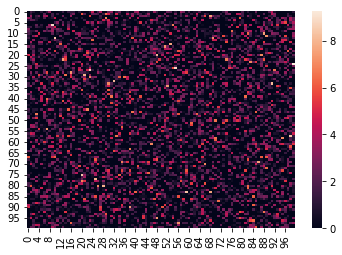

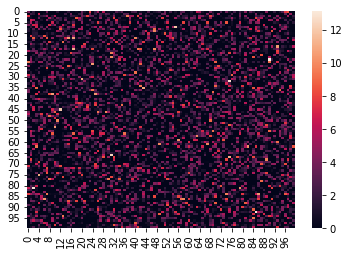

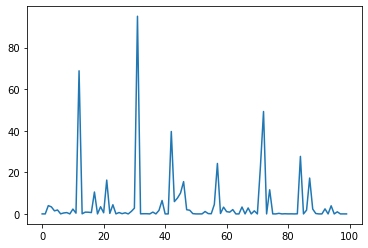

500
1000
1000 25


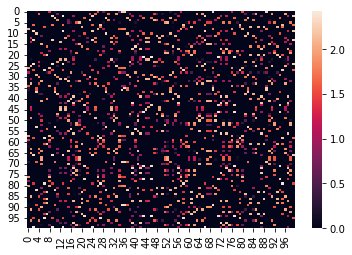

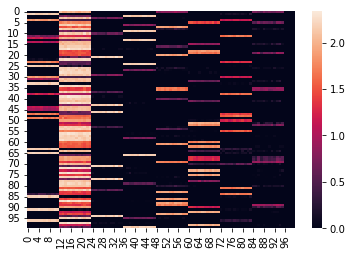

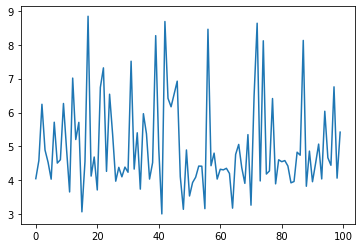

1500
2000


IndexError: index 2000 is out of bounds for axis 0 with size 2000

In [10]:
b = baseline*np.ones(K)

vmean_all_rep = [] ## firing rate of neurons
trials_all_rep = []
for sim_rep in range(0,1):
    
    ## Initialize weights
    W = np.maximum(np.random.normal(0,W_std,(K,N)),0) ## feedforward 
    V = np.maximum(np.random.normal(0,V_std,(K,K)),0)  ## recurrent 
    y = np.zeros(K) ## recurrent input
    
    ## Generate inputs for each sensory observation
    P = len(np.unique(np.concatenate((trial1x, trial2x)))) + 1 ## add one for reward
    each_input = int(np.floor(N/P)) ## num input neurons that will fire for each input observation
    x_rate= np.zeros((P,N))
    for p_each in range(P):
        x_rate[p_each, p_each*each_input: (1+p_each)*each_input] = input_fr
    
    ## Generate trials
    x_all = np.zeros((num_trials, len(trial1x), N))
    trials = np.random.choice(2,num_trials)
    for trial_number in range(0, num_trials):
        trial = trials[trial_number]
        if trial == 0:
            x_all[trial_number,:,:] = x_rate[trial1x]
        else:
            x_all[trial_number,:,:] = x_rate[trial2x]



    x = np.zeros(N)
    refractory = np.zeros(K)
    refractory_input = np.zeros(N)
    y_all = np.zeros(K)
    vmean = []
    time_since_spike = 7*np.ones(K)

    for rep in range(0, 4000):

        if rep%500==0:
            print(rep)
        for curr_P in range(0,len(trial1x)):
            v_all = []
            
            for t in range(0,each_obs_time):
                
                ## Find current input
                if (curr_P == 14) and trials[rep] == 0 and np.random.uniform()>prob_nonrw:
                    spiking_input = np.where(np.random.uniform(0,1,N)<(x_rate[P-1]/1000))

                elif  (curr_P == 19) and trials[rep] == 1 and np.random.uniform()>prob_nonrw:
                    spiking_input = np.where(np.random.uniform(0,1,N)<(x_rate[P-1]/1000)) 

                else:
                    spiking_input = np.where(np.random.uniform(0,1,N)<(x_all[rep, curr_P,:]/1000))

                ## Input neuron spike/no spike
                for neur in range(0,N):
                    if neur in spiking_input[0] and refractory_input[neur] == 0: ## ie. neuron spikes
                        x[neur] = np.exp(-1/tau)* (1+x[neur])
                        refractory_input[neur]= ref_time
                    else: ## neuron didn't spike
                        x[neur] = np.exp(-1/tau)* (x[neur])

                ## Calculate firing rate of recurrent neuron 
                eta = eta0*np.exp(-time_since_spike/tau_ref)
                ubar = (W@x) + (V@y_all) + b - eta
                inh = np.log(np.sum(np.exp(ubar)))
                v = vhat*np.exp(ubar)/(np.sum(np.exp(ubar)))
                v_all.append(v)
                spiking_neurons = np.where(np.random.uniform(0,1, K)<v/1000)

                for neur in range(0,K):
                    
                    if neur in spiking_neurons[0] and refractory[neur] == 0: ## spiking neurons

                        refractory[neur]= ref_time
                        time_since_spike[neur] = -1

                        y_all[neur] = np.exp(-1/tau)*(1+y_all[neur])
                        
                        ## Weight update
                        W[neur,:] = np.maximum(W[neur,:] + beta*(np.exp(-W[neur,:])*x-0.1),0)
                        V[neur,:] = np.maximum(V[neur,:] + beta*(np.exp(-V[neur,:])*y_all-0.1),0)
                        
                        V[neur, neur] = 0  ## no autapse


                    else:
                        y_all[neur] = np.exp(-1/tau)*(y_all[neur]) ## non-spiking neurons


                

                refractory[refractory>0] = refractory[refractory>0]-1
                refractory_input[refractory_input>0] = refractory_input[refractory_input>0]-1
                time_since_spike = time_since_spike + 1
            vmean.append(np.mean(np.array(v_all), axis = 0))




        if rep%1000==0:
            print(rep, curr_P)
            sb.heatmap(V)
            plt.show()
            sb.heatmap(W)
            plt.show()
            plt.plot(np.mean(vmean, axis = 0))
            plt.show()
    
    vmean_all_rep.append(vmean)
    trials_all_rep.append(trials)

In [11]:
num_trials = len(trials)
trials = np.array(trials)
vmean = np.array(vmean)
vmean0 = np.zeros((K,len(trial1x), np.sum(trials==0)))
vmean1 = np.zeros((K,len(trial1x), np.sum(trials==1)))
count0 = 0
count1 = 0

for counter in range(0, 1800):##len(trials)):
    ##print(counter)
    trial = trials[counter]
    if trial ==0:
        vmean0[:, :, count0] = vmean[counter*len(trial1x):(1+counter)*len(trial1x),:].T
        count0 = count0 +1
    else:
        vmean1[:, :, count0] = vmean[counter*len(trial1x):(1+counter)*len(trial1x),:].T
        count1 = count1 + 1
    if counter >0:
        vmean_comb = np.dstack((vmean_comb, vmean[counter*len(trial1x):(1+counter)*len(trial1x),:].T))
    else:
        vmean_comb = vmean[counter*len(trial1x):(1+counter)*len(trial1x),:].T

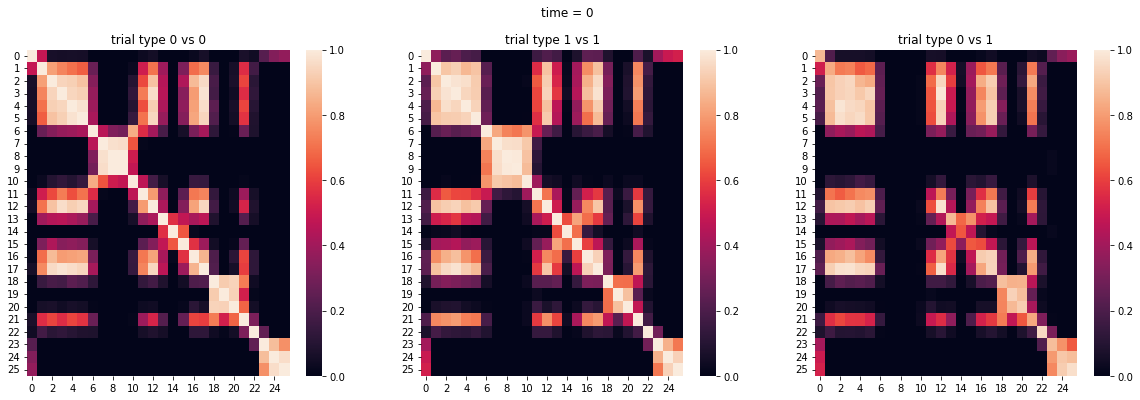

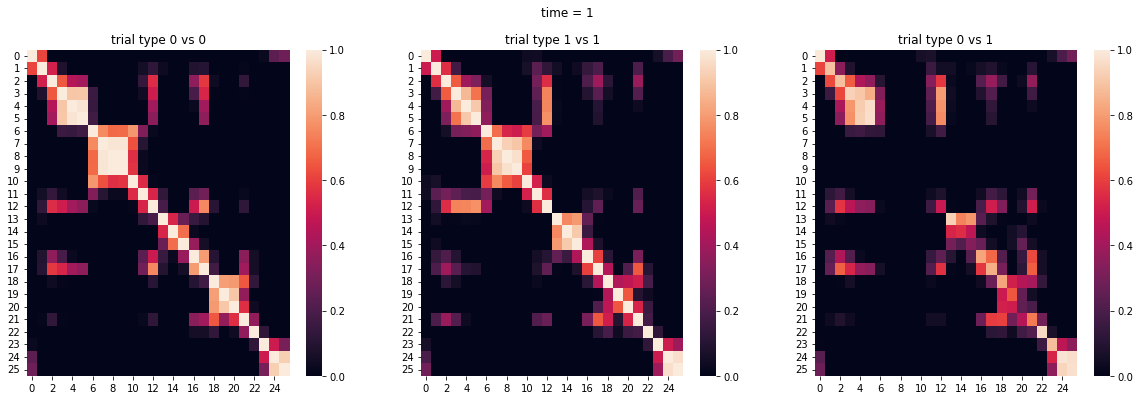

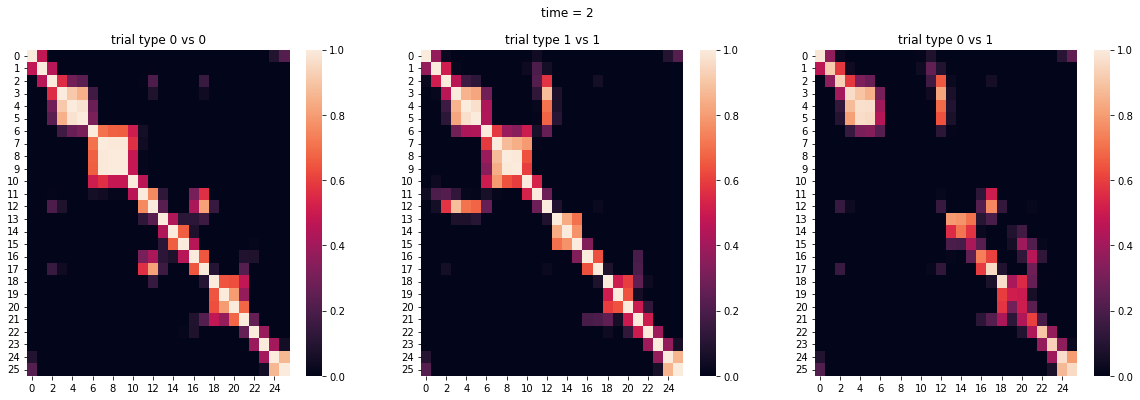

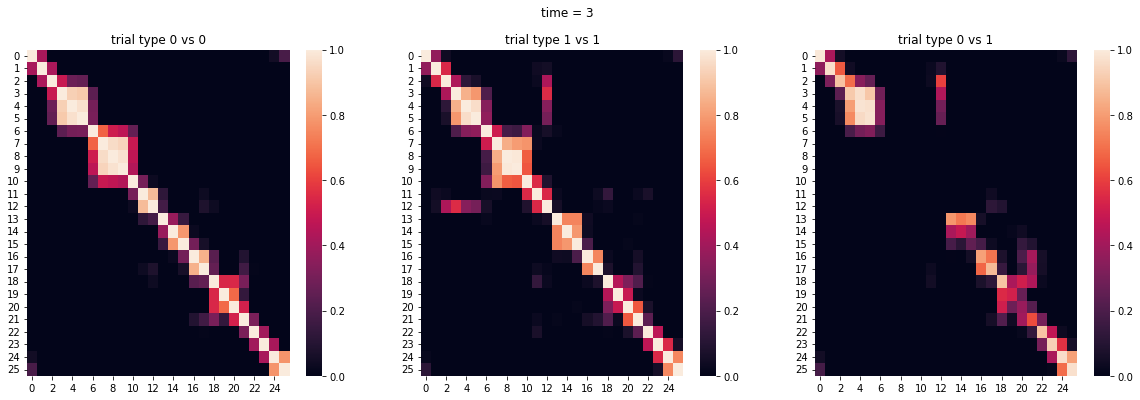

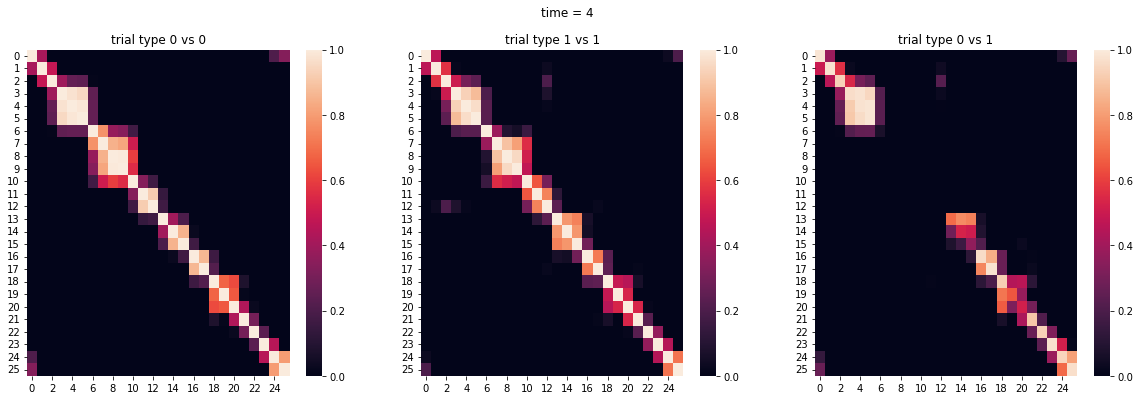

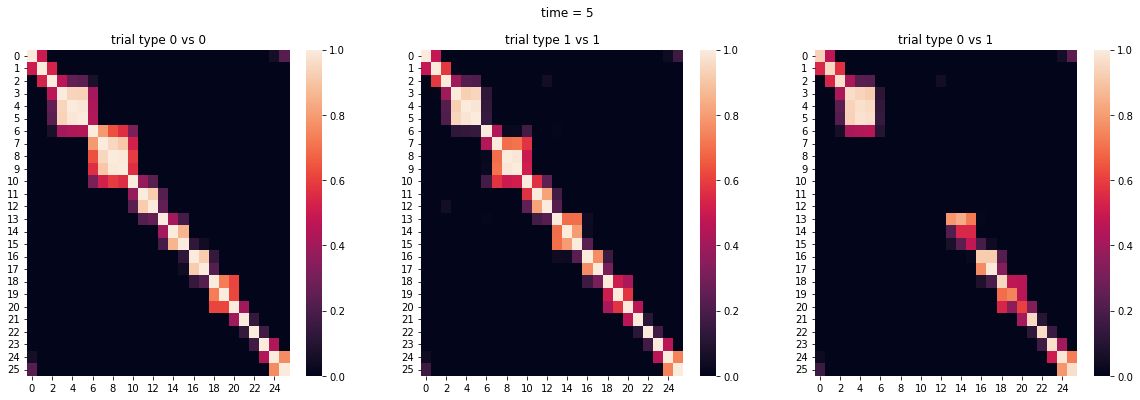

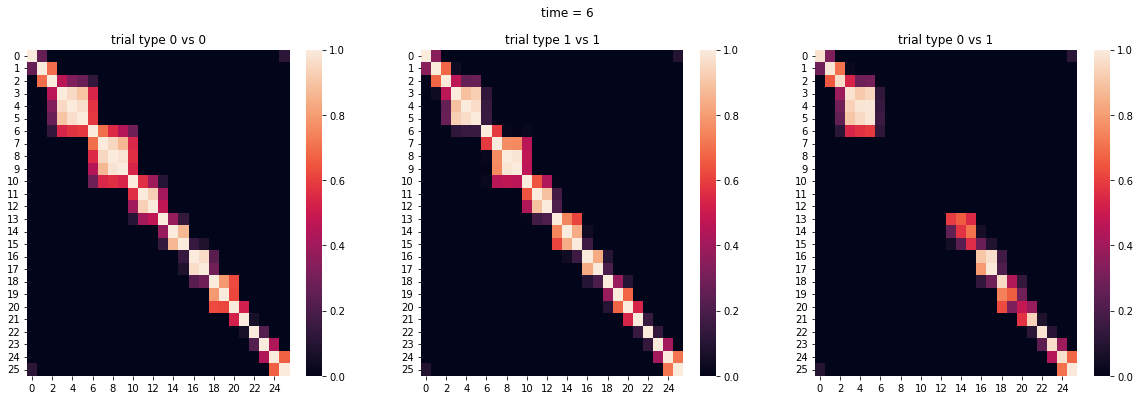

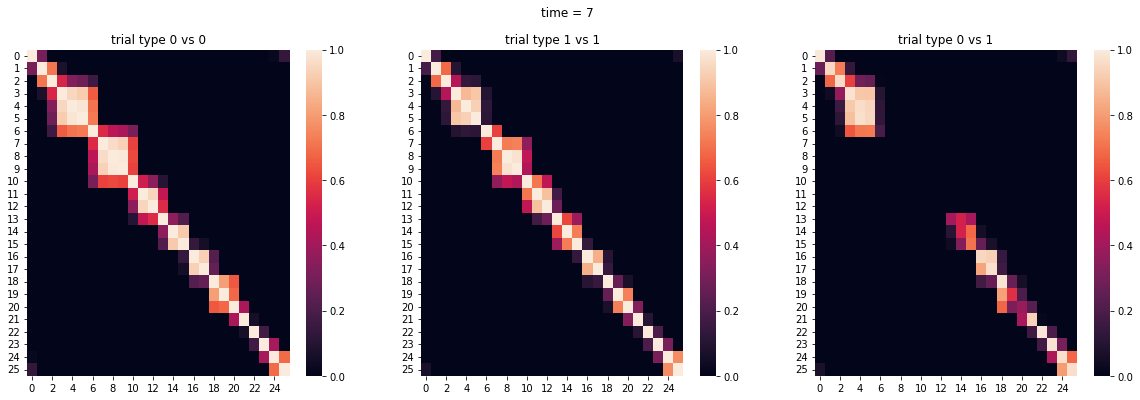

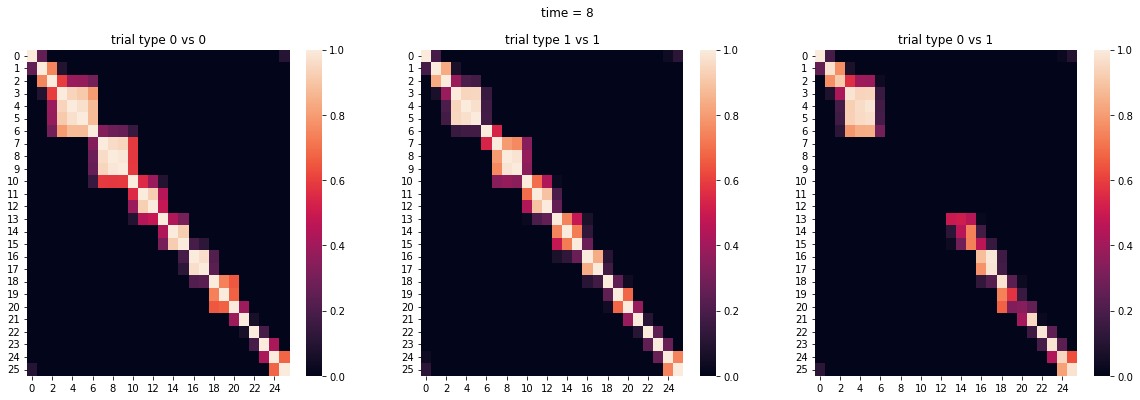

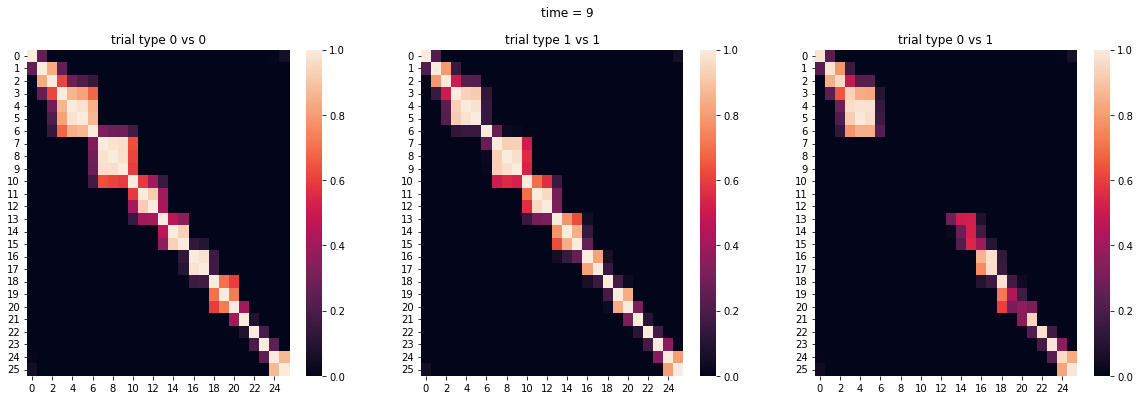

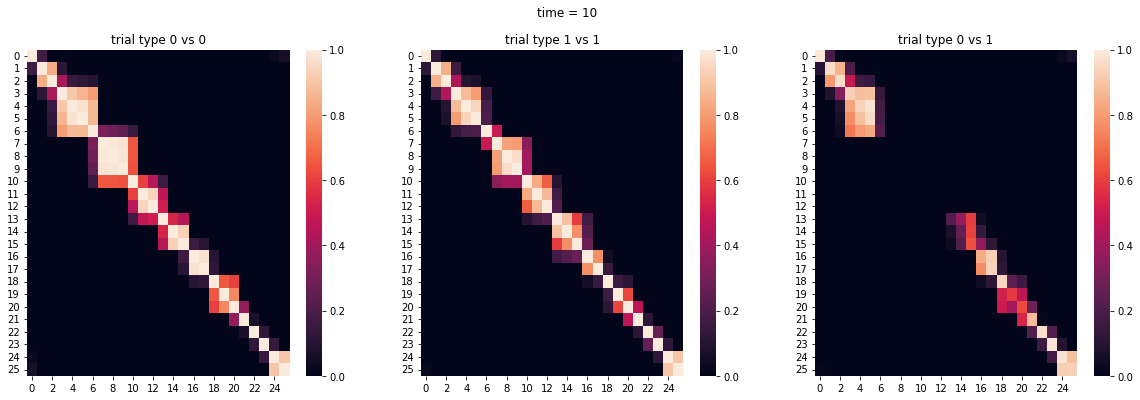

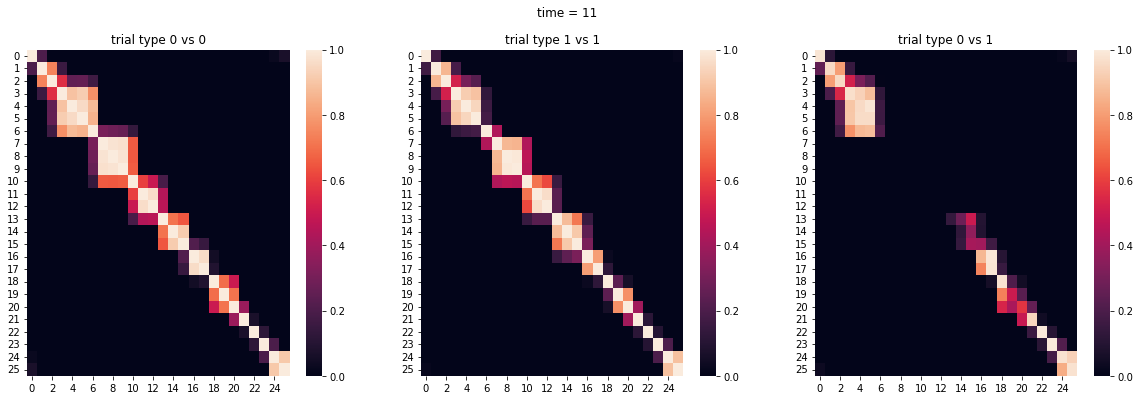

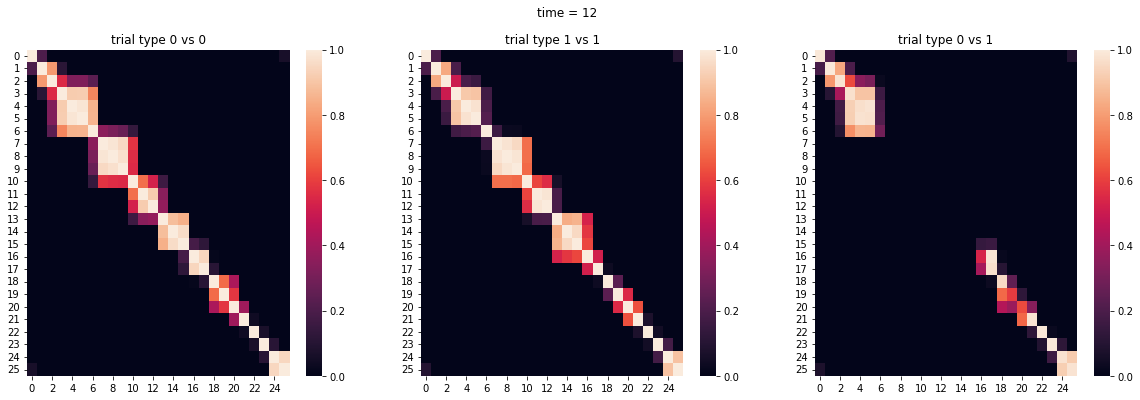

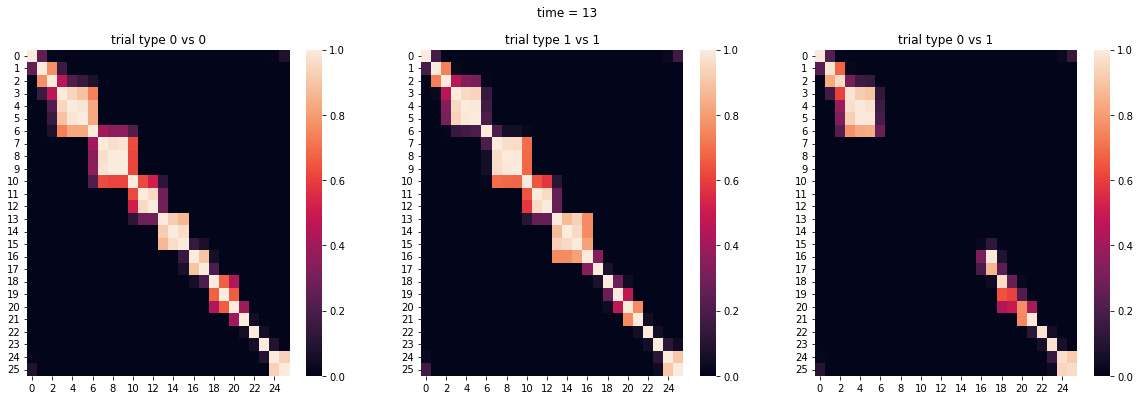

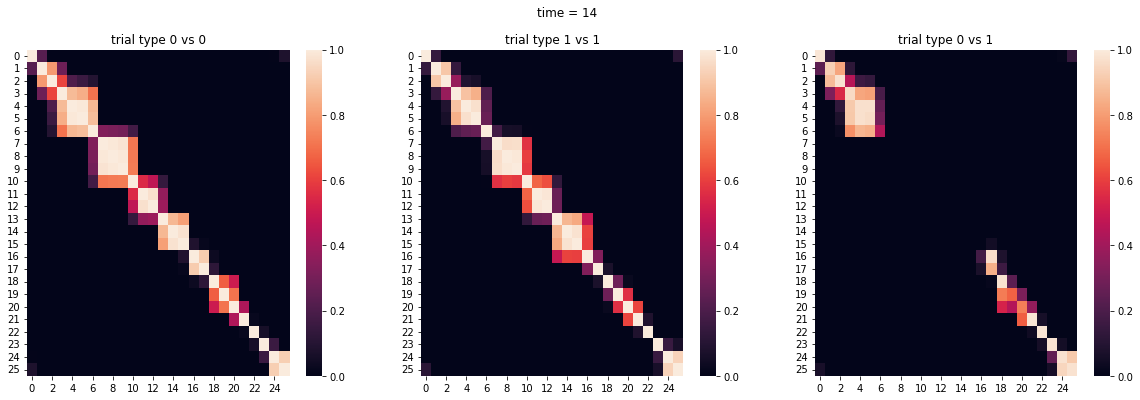

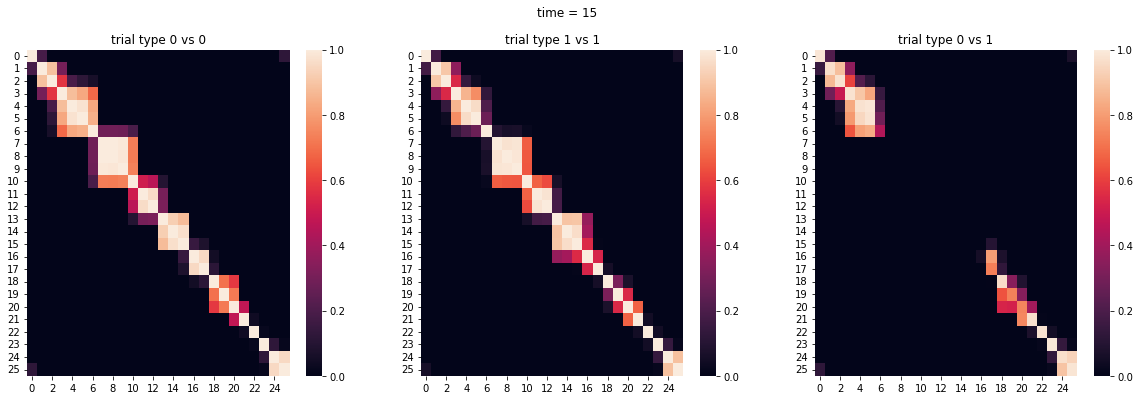

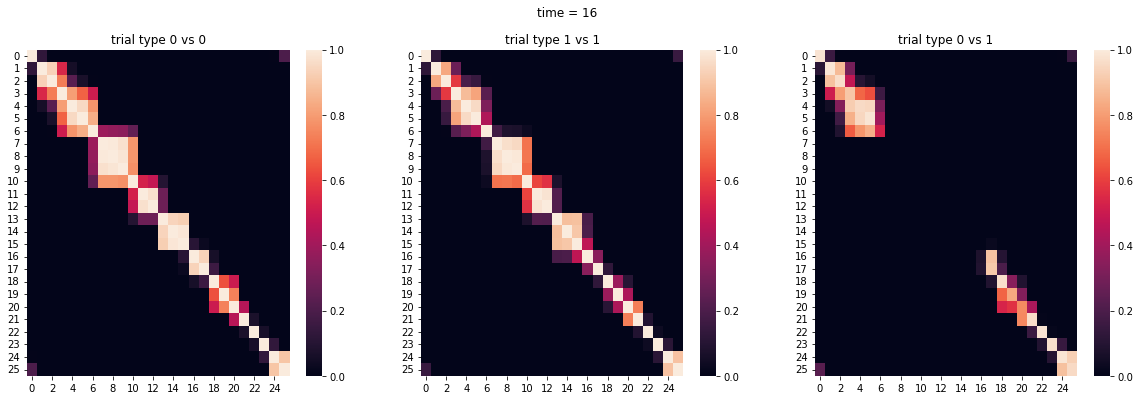

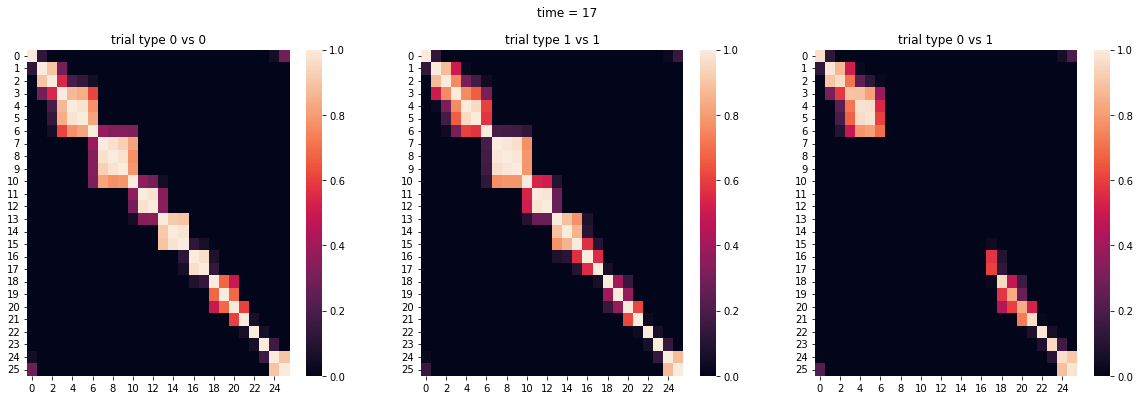

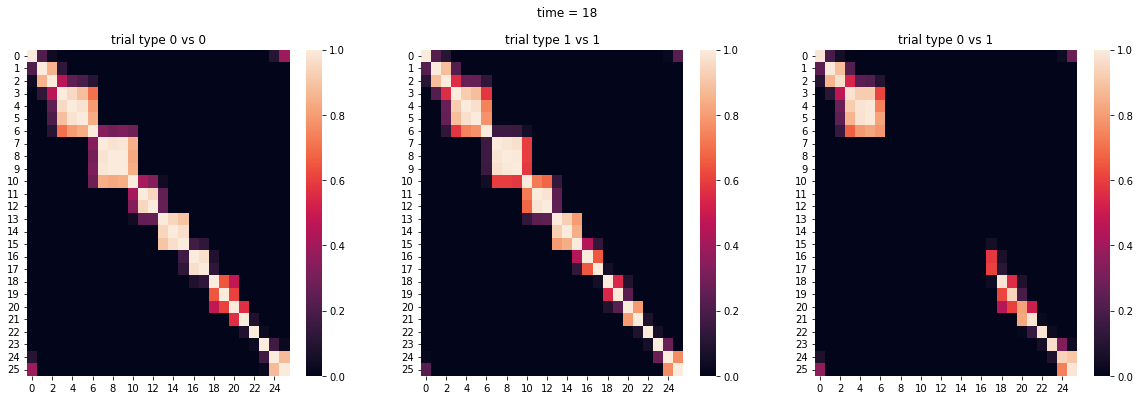

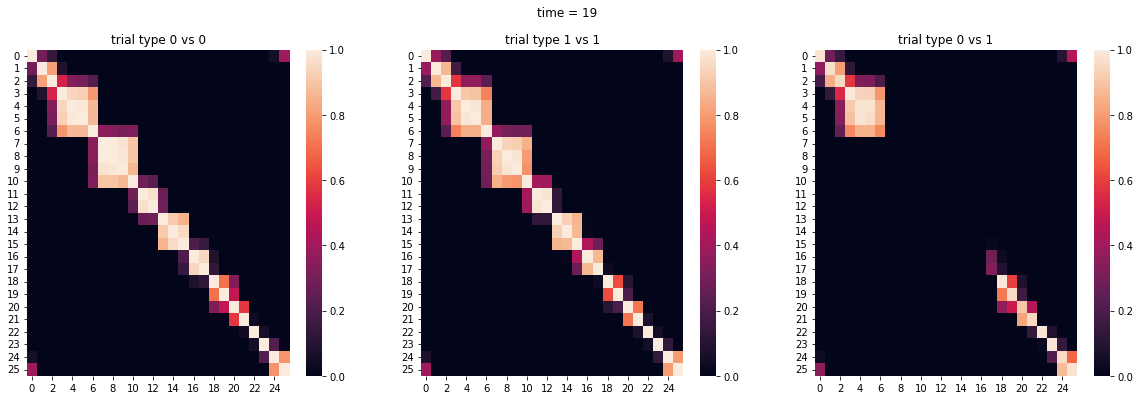

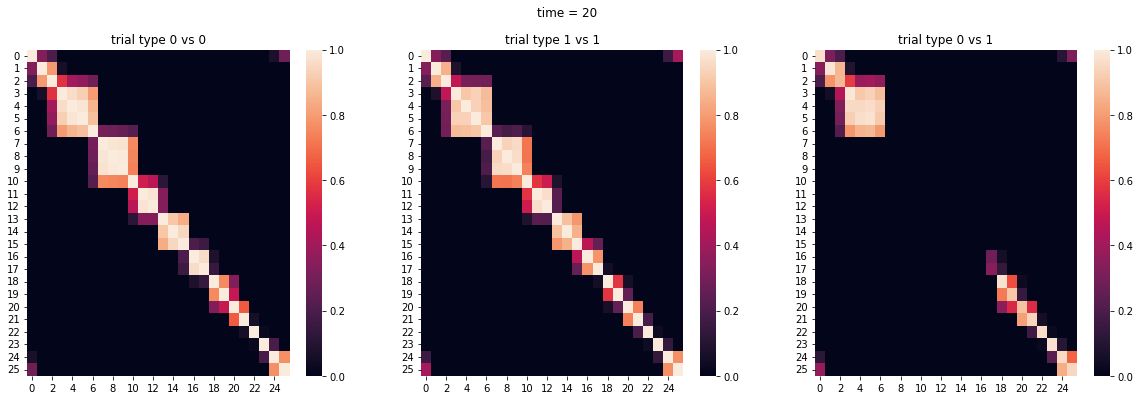

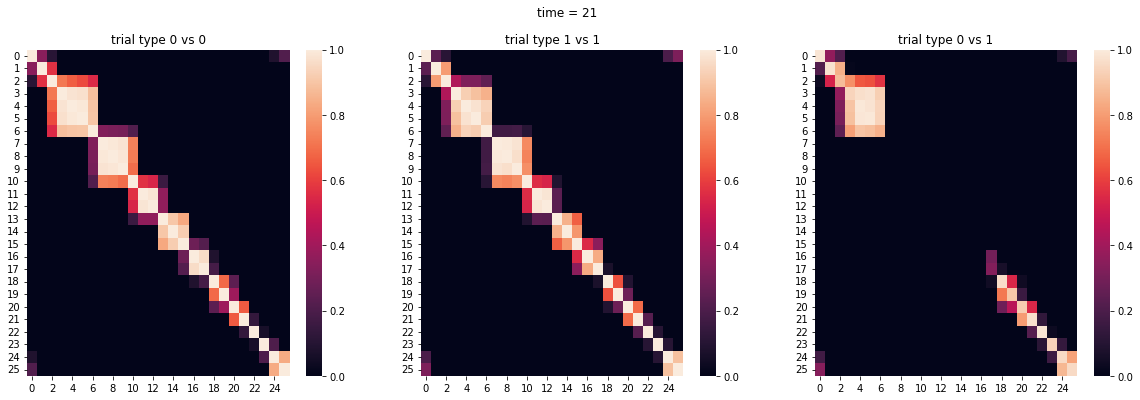

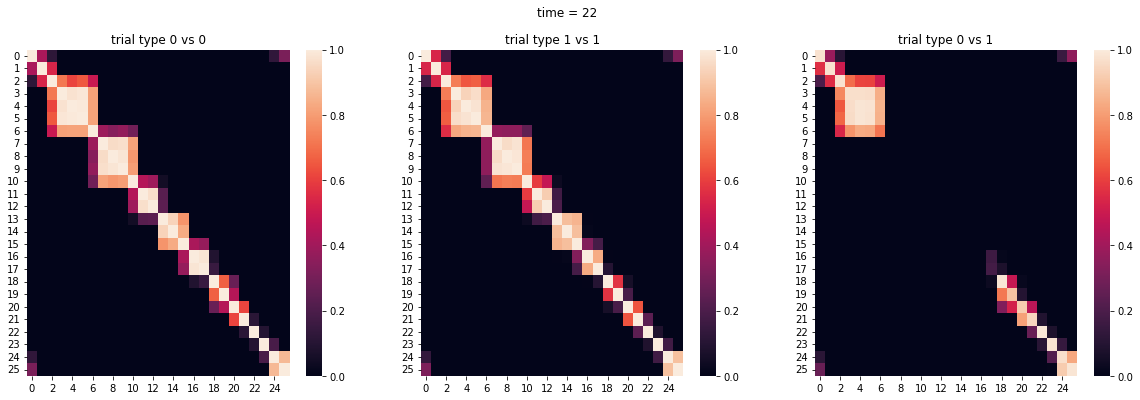

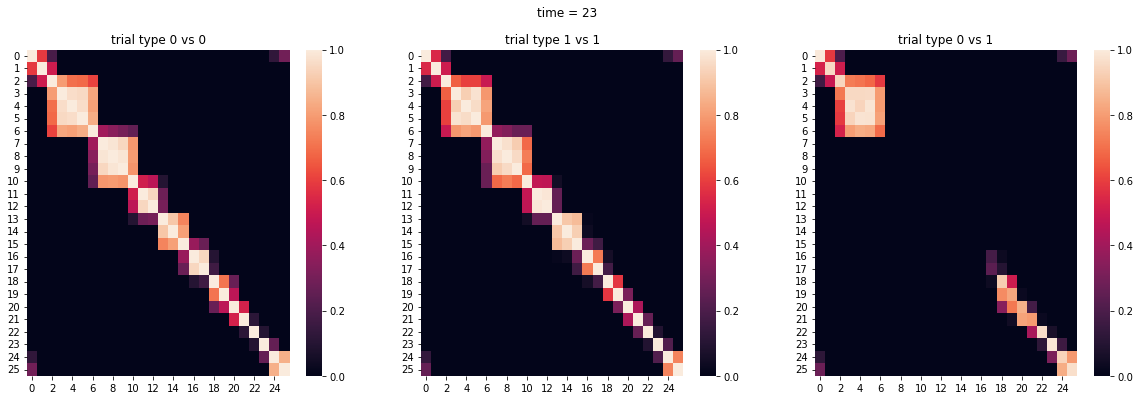

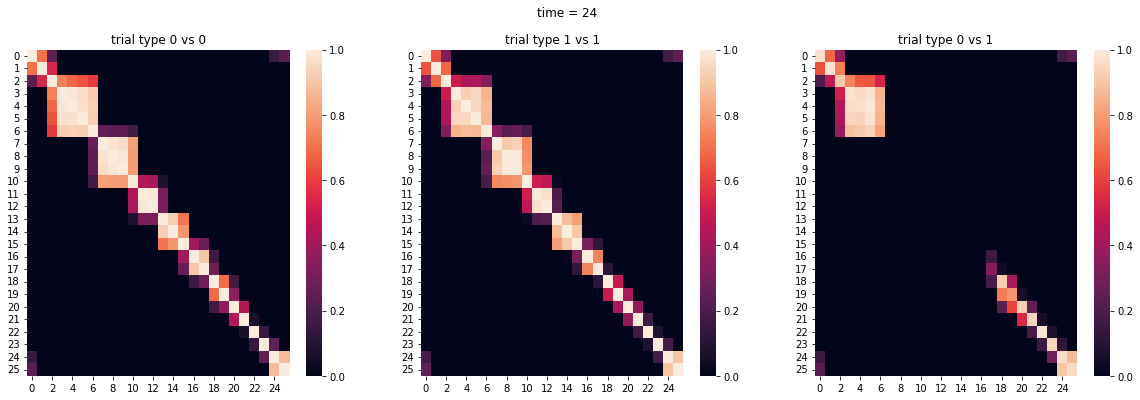

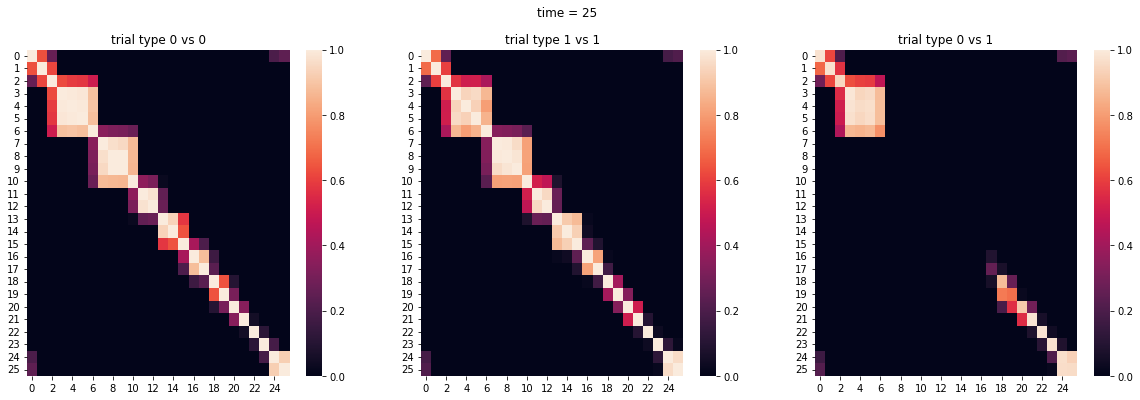

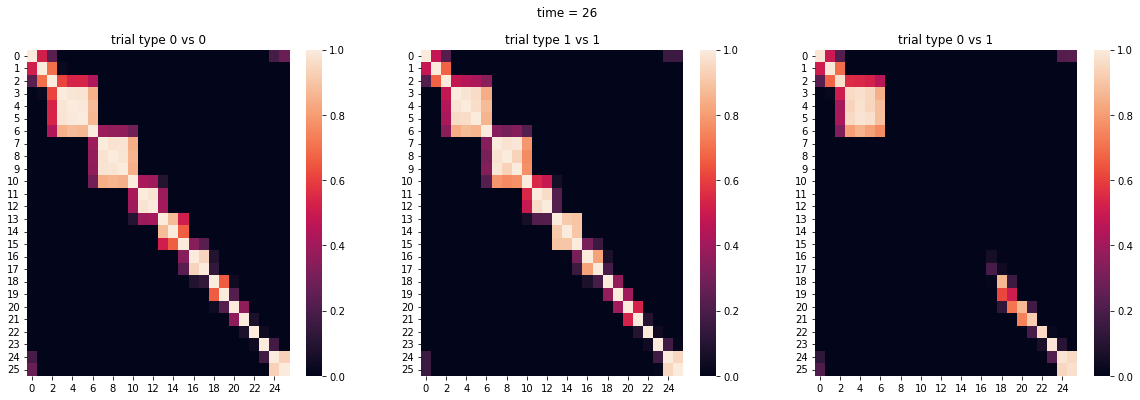

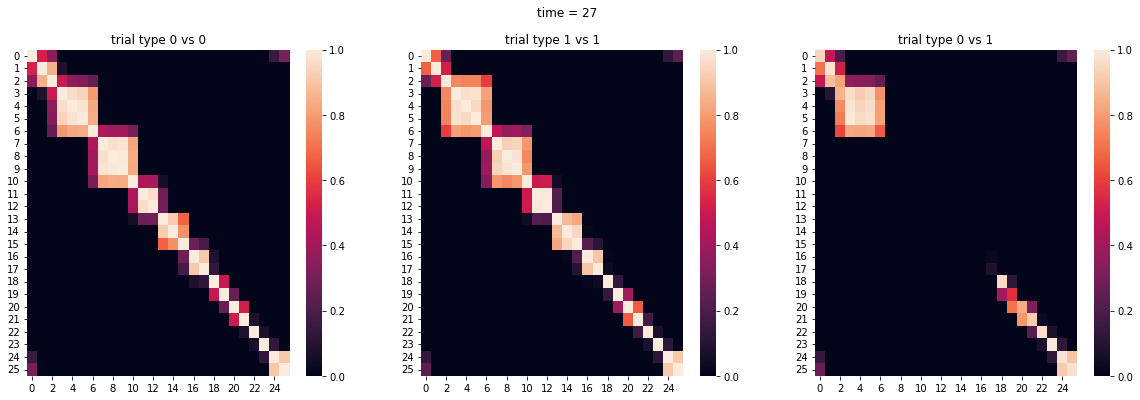

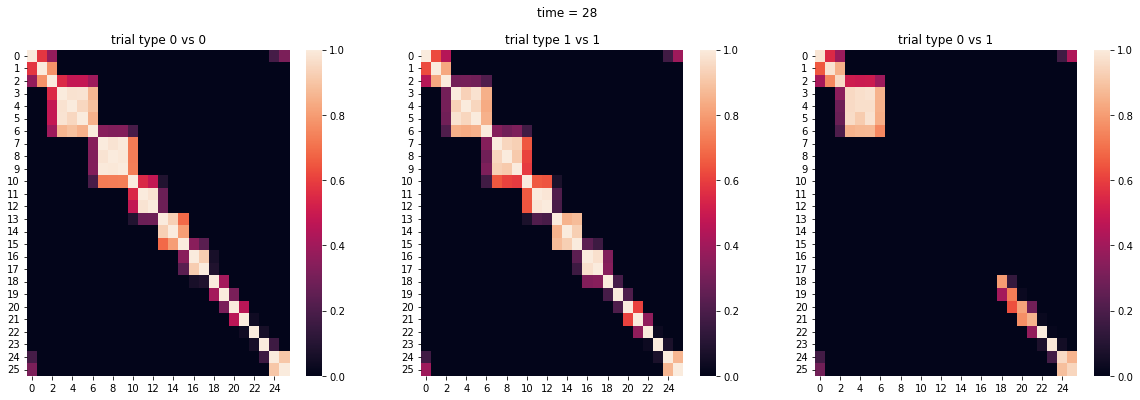

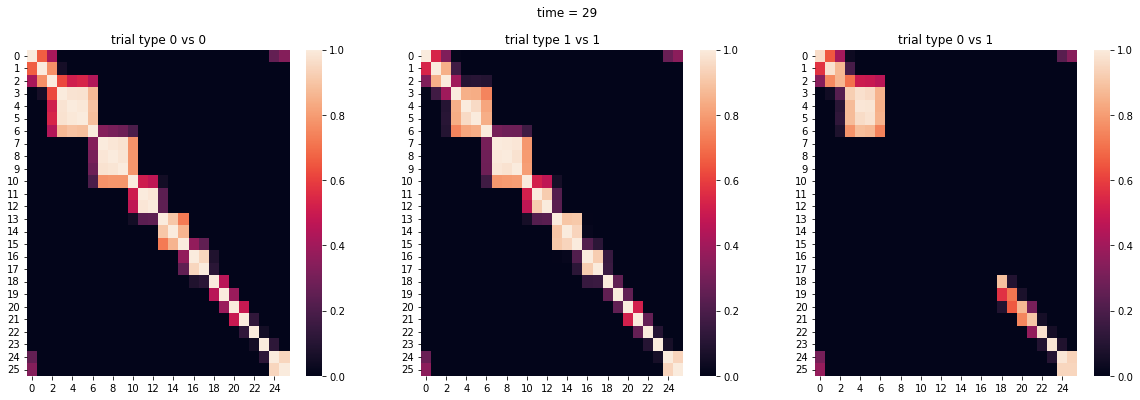

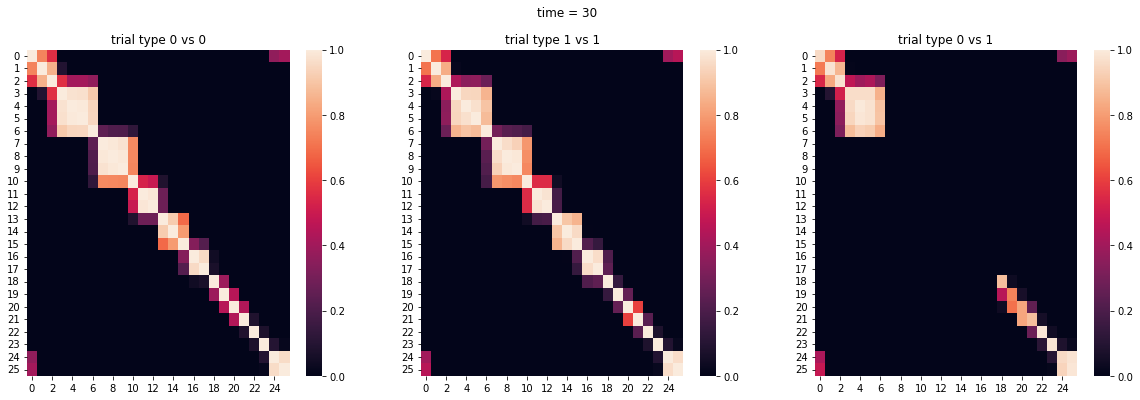

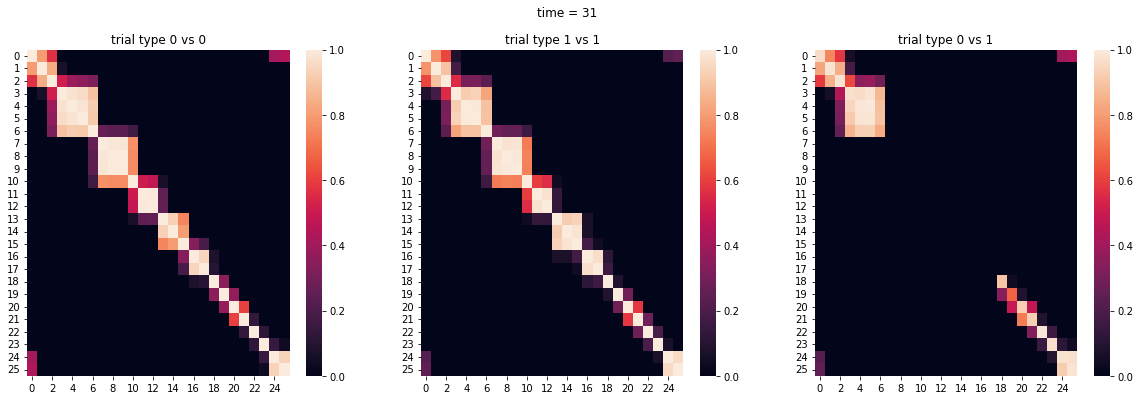

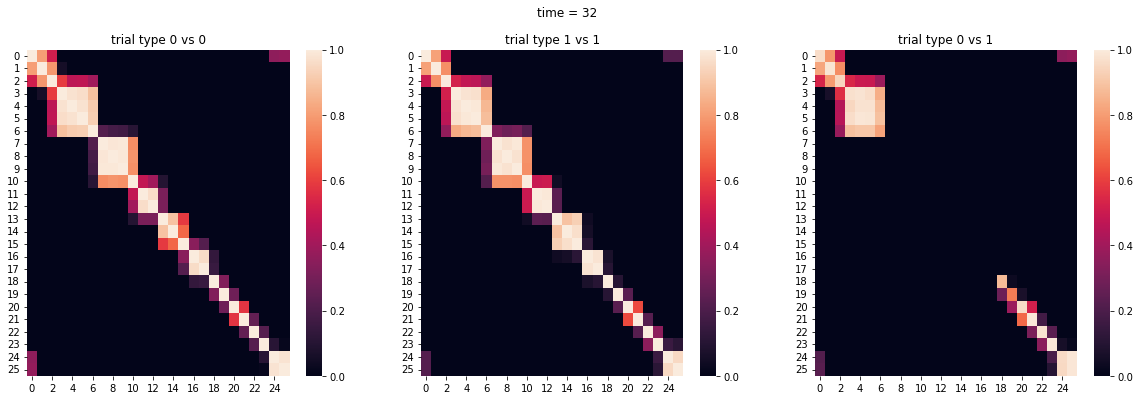

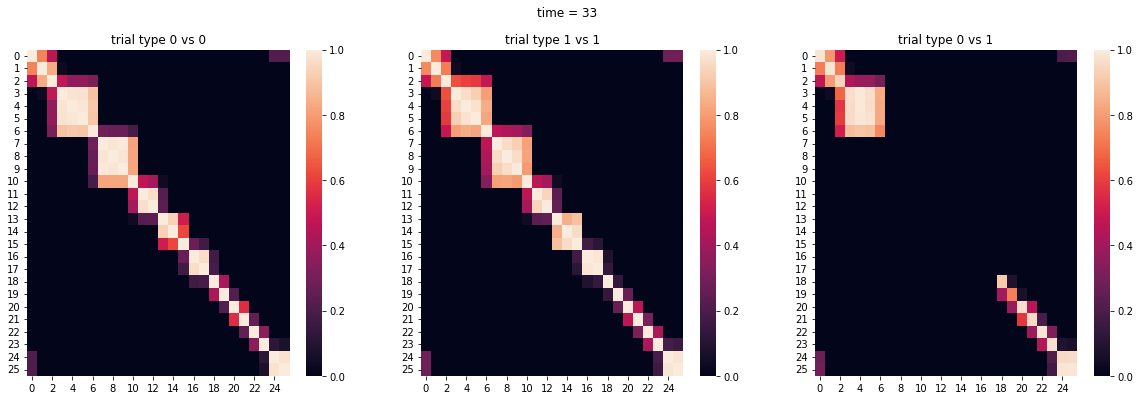

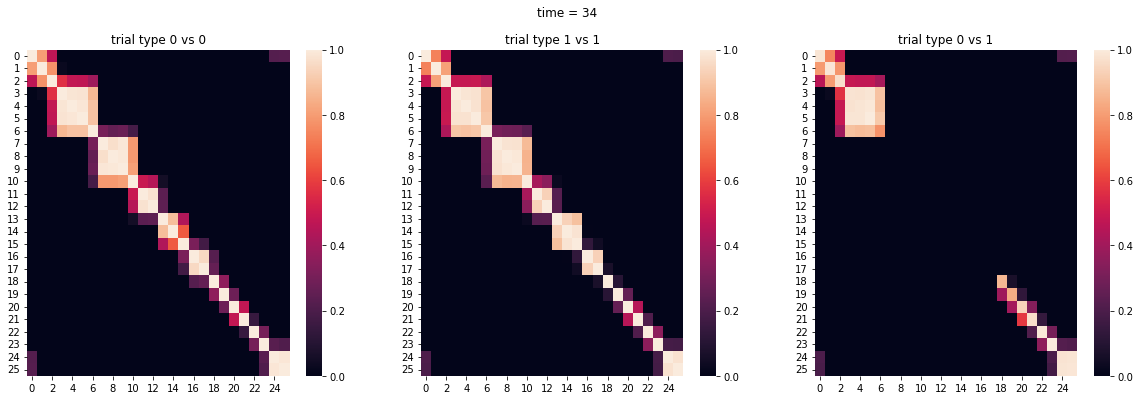

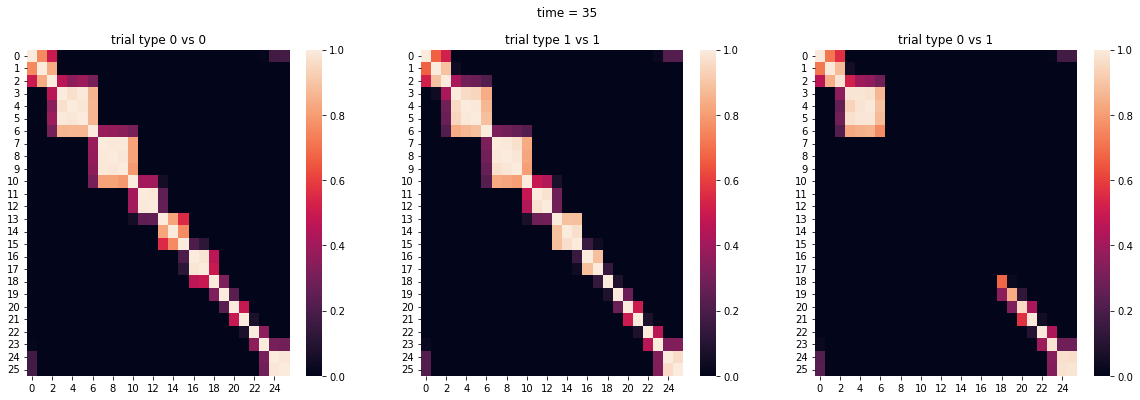

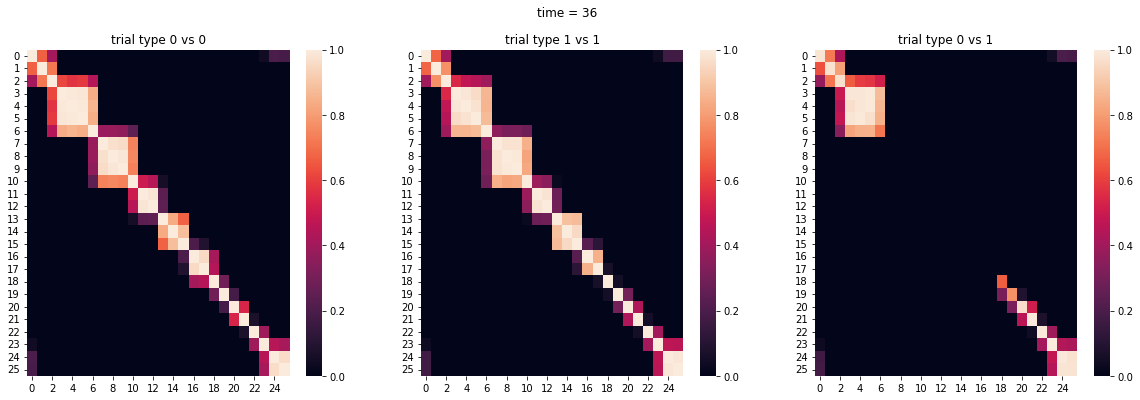

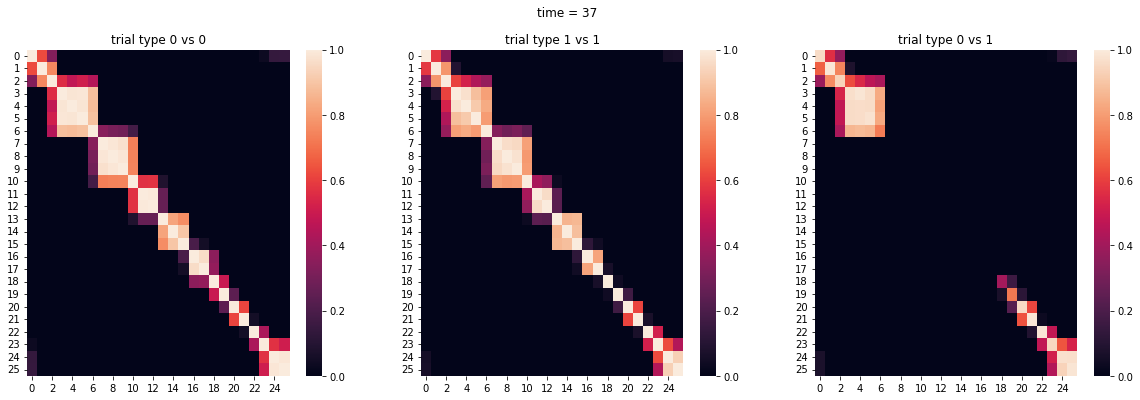

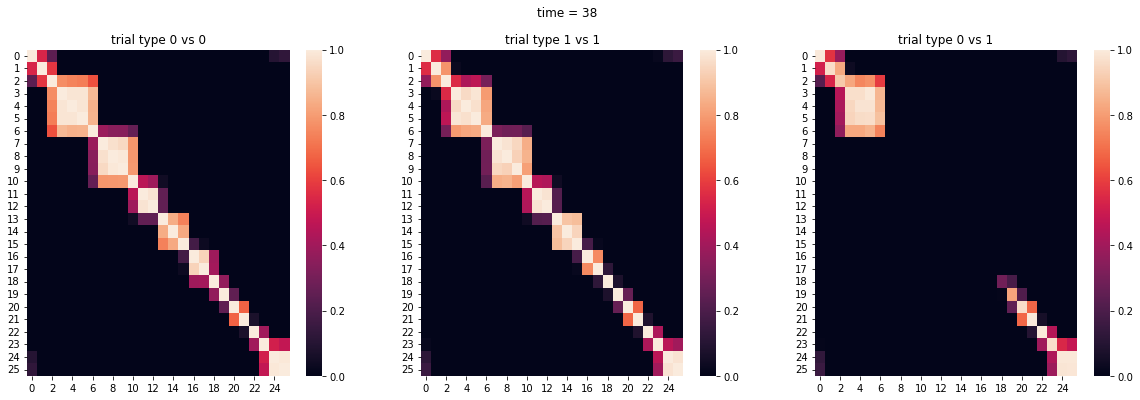

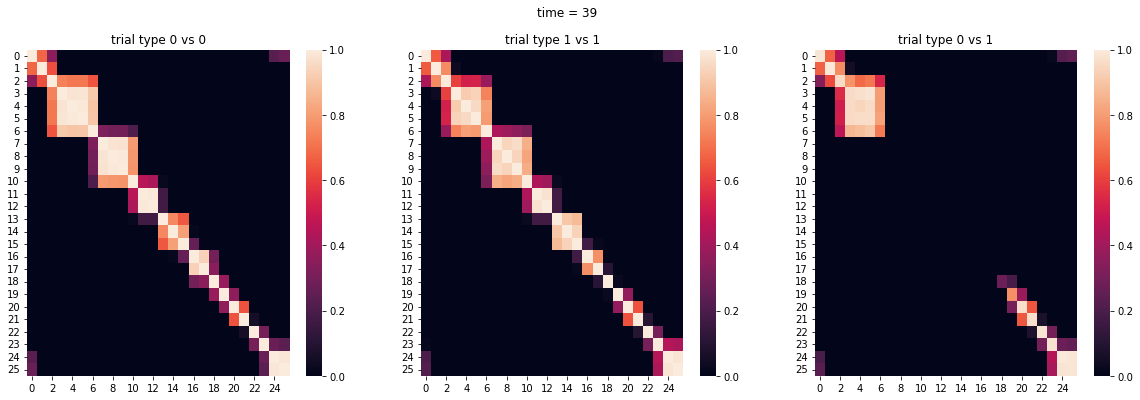

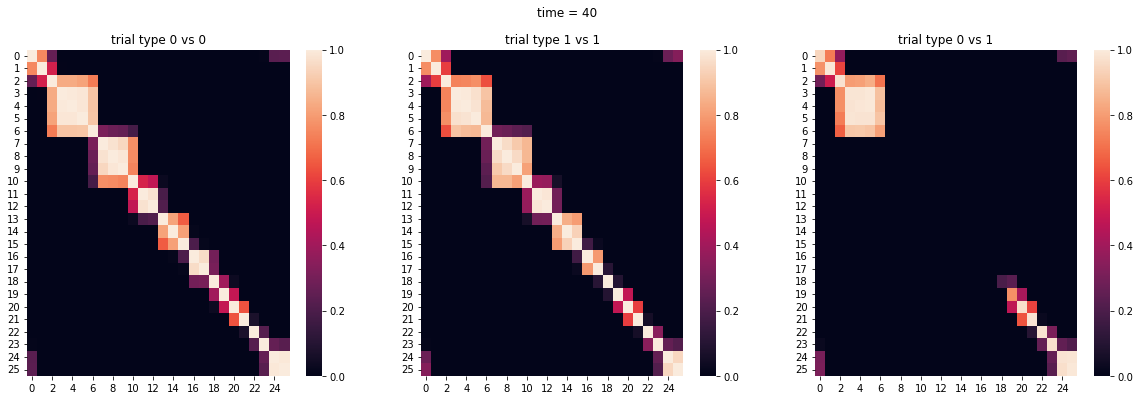

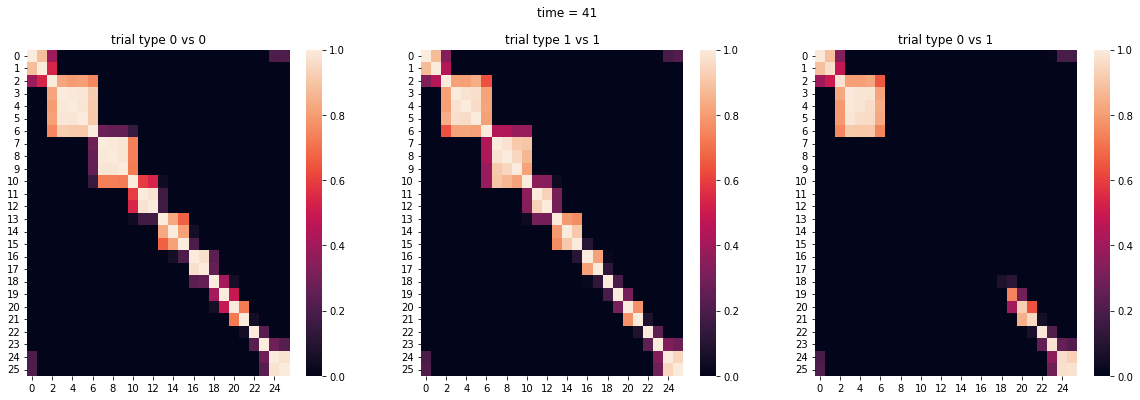

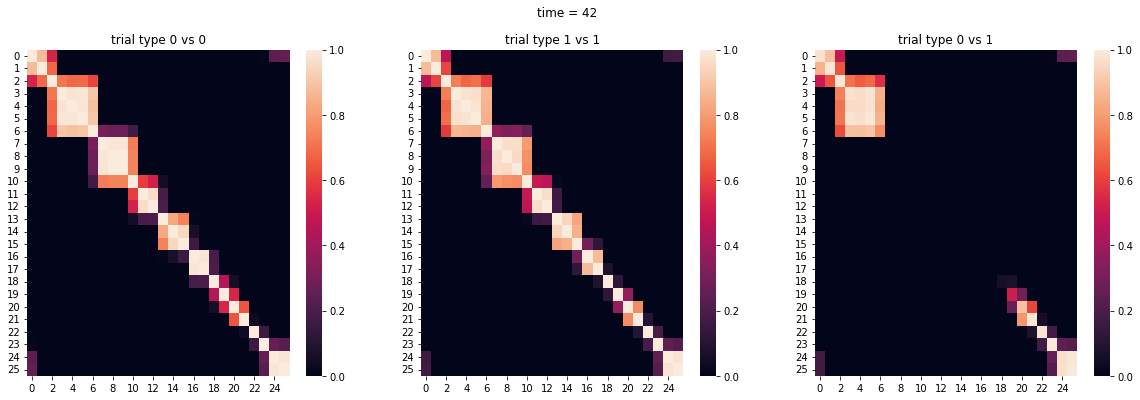

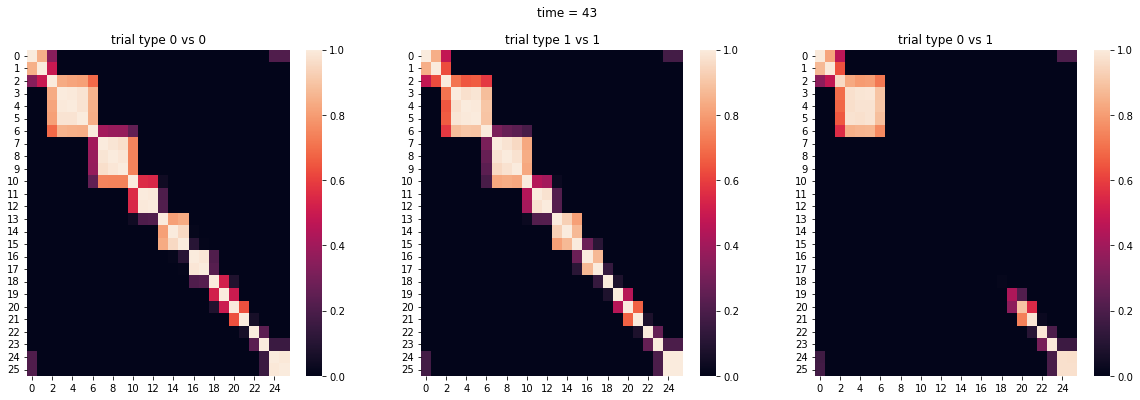

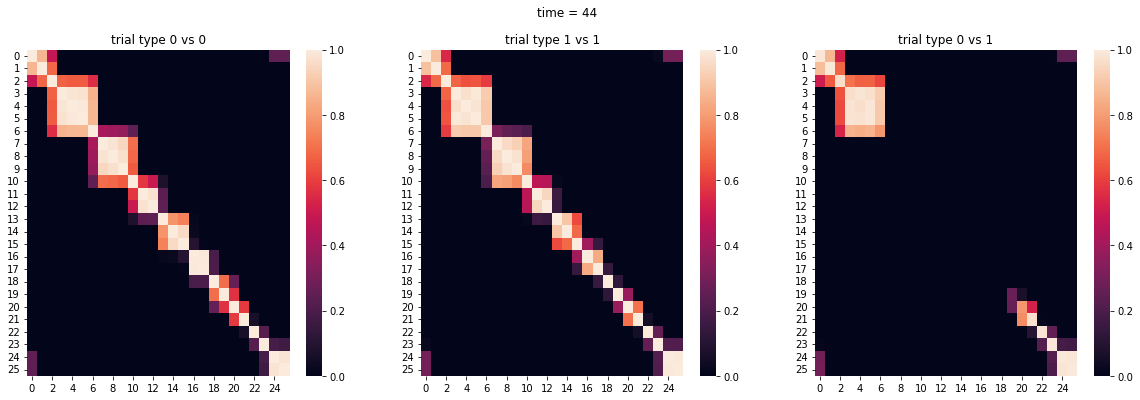

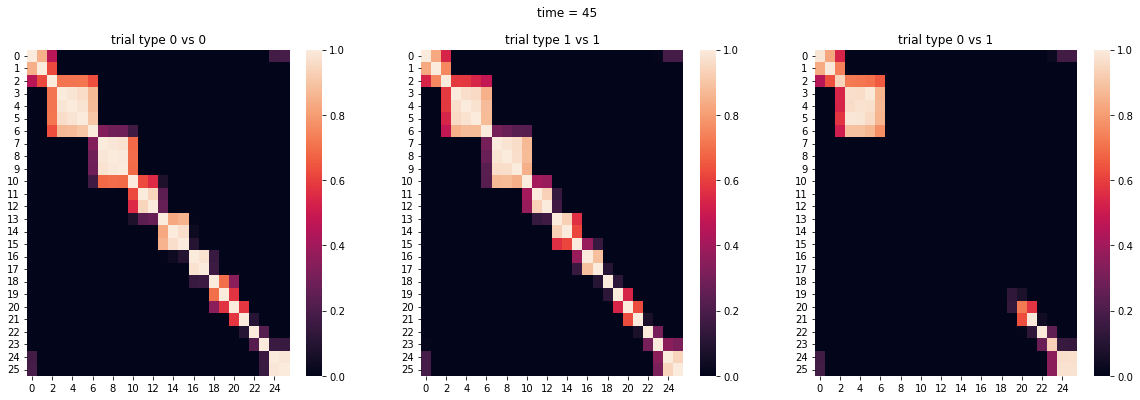

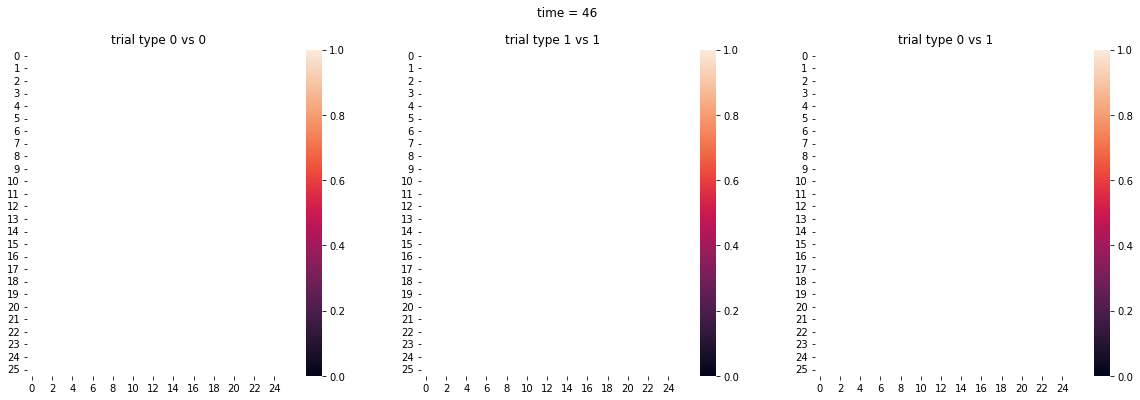

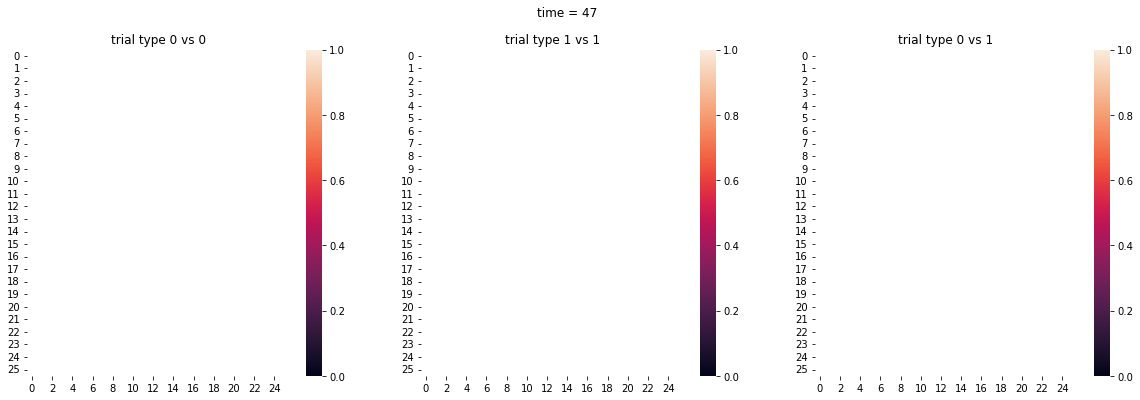

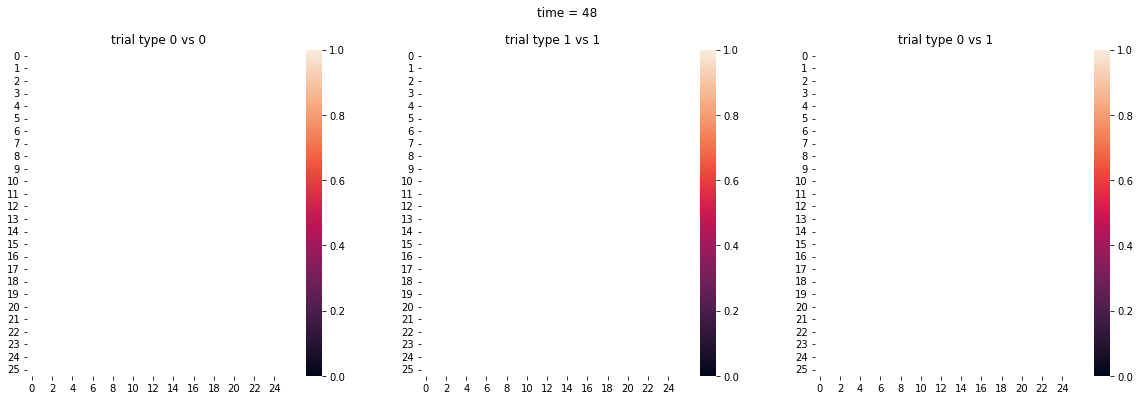

In [17]:
each_avg = 20
rep_times = int(np.floor(np.minimum(np.shape(vmean1)[2], np.shape(vmean0)[2])/each_avg))
for avging in range(0, rep_times):
    fig, axs = plt.subplots(1,3,figsize=(20,6))
    corrplot01 = np.zeros((len(trial1x), len(trial1x)))
    corrplot00 = np.zeros((len(trial1x), len(trial1x)))
    corrplot11 = np.zeros((len(trial1x), len(trial1x)))
    for i in range(len(trial1x)):
        for j in range(len(trial2x)):
            zeroi = np.nan_to_num(np.mean(vmean0[:,i,avging*each_avg:(1+avging)*each_avg], axis = 1))
            onej = np.nan_to_num(np.mean(vmean1[:,j,avging*each_avg:(1+avging)*each_avg], axis = 1))
            zeroj = np.nan_to_num(np.mean(vmean0[:,j,avging*each_avg:(1+avging)*each_avg], axis = 1))
            onei = np.nan_to_num(np.mean(vmean1[:,i,avging*each_avg:(1+avging)*each_avg], axis = 1))
            corrplot01[i,j] = scipy.stats.pearsonr(zeroi, onej)[0]
            corrplot00[i,j] = scipy.stats.pearsonr(zeroi, zeroj)[0]
            corrplot11[i,j] = scipy.stats.pearsonr(onei, onej)[0]
    sb.heatmap(corrplot00, vmin = 0, vmax = 1, ax = axs[0])
    axs[0].set_title('trial type 0 vs 0')
    sb.heatmap(corrplot11, vmin = 0, vmax = 1, ax = axs[1])
    axs[1].set_title('trial type 1 vs 1')
    sb.heatmap(corrplot01, vmin = 0, vmax = 1, ax = axs[2])
    axs[2].set_title('trial type 0 vs 1')
    fig.suptitle('time = ' + str(avging))
    plt.show()
    

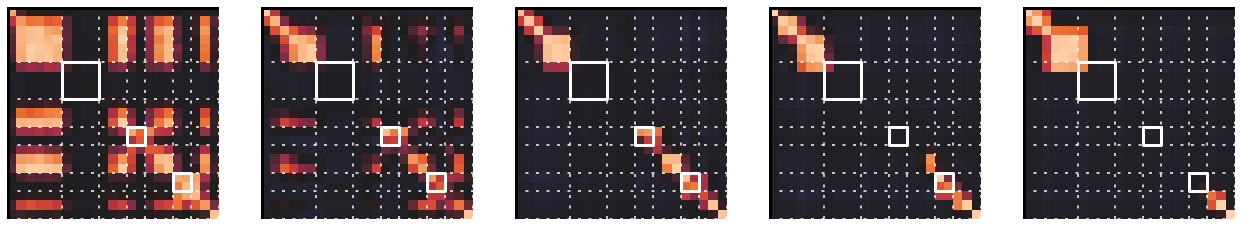

In [23]:
sb.set_style("whitegrid", {'axes.grid' : False})
fig, axs = plt.subplots(1,5, figsize = (22,4))
##fig, axs = plt.subplots(1,5, figsize = (12,2))
counter = 0
for stage in [0,1,5,15,45]:
##for stage in [0,1,2,13,17]:
##for stage in [0,1,7,10,13]:
##for stage in [0,1,2,7,10]:
##for stage in [0,2,7,9,10]:
##[0,1,2,3,18]:
    
    corrplot01 = np.zeros((len(trial1x), len(trial1x)))
    
    for i in range(len(trial1x)):
        for j in range(len(trial2x)):
            zeroi = np.nan_to_num(np.mean(vmean0[:,i,stage*each_avg:(1+stage)*each_avg], axis = 1))
            onej = np.nan_to_num(np.mean(vmean1[:,j,stage*each_avg:(1+stage)*each_avg], axis = 1))
            
            corrplot01[i,j] = scipy.stats.pearsonr(zeroi, onej)[0]
    
    
    sb.heatmap(corrplot01[0:23,0:23], ax= axs[counter], cmap = 'icefire', vmin= -1, vmax = 1, cbar= False,rasterized=True)
    for lines in [6,10,13,15,18,20,23]:
        axs[counter ].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)
        axs[counter ].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)
    ##axs[counter].set_yticks(np.arange(0,23,4), np.arange(0,230,40), rotation = 45)
    ##axs[counter].set_xticks(np.arange(0,23,4), np.arange(0,230,40),rotation = 45)
    axs[counter ].axhline(y=0, color='k',linewidth=5)
    axs[counter].axhline(y=corrplot01.shape[1], color='k',linewidth=5)
    axs[counter ].axvline(x=0, color='k',linewidth=5)
    axs[counter ].axvline(x=corrplot01.shape[0], color='k',linewidth=5)
    ##axs[counter].set_title('time ' + str(avging))
    for (low, high) in [(6, 10), (13, 15), (18, 20)]:
        axs[counter].plot([low, high, high, low, low], [low, low, high, high, low], color='white',linewidth=3) 
    axs[counter].set_aspect('equal')
    axs[counter].axis('off')
    ##axs[fig_count].set_title(stage*n_iter)
    axs[counter].grid(False)
    counter+=1
##plt.savefig('../FIGURES/RNN5_rep3_correlation.pdf', format='pdf', dpi=500)